# Navier Stokes Equations using Fourier Neural Operator

In this notebook, we will solve the Navier Stokes equations using Fourier Neural Operator. The Navier Stokes equations are given by

$$
\begin{align*}
\partial_t w(x,t) + u(x,t) \cdot \nabla w(x,t) &= \nu \Delta w(x,t) + f(x)\\
\nabla \cdot u(x,t) &= 0\\
w(x,0) &= w_0(x)
\end{align*}
$$

where $w(x,t)$ is the velocity field, $u(x,t)$ is the velocity field, $\nu$ is the viscosity, $f(x)$ is the external force, and $w_0(x)$ is the initial velocity field.

In [13]:
from FNO.fno_2d_time import FNO2DTime
from FNO.lploss import LpLoss
from FNO.train import train_model
from utilities.utils import MatlabFileReader
import matplotlib.pyplot as plt
import torch

## Data

In [9]:
data_path = 'NavierStokes_V1e-5_N1200_T20.mat'
mat_data = MatlabFileReader(data_path, device='cuda', to_tensor=True)
mat_data

MatlabFileReader(file_path=NavierStokes_V1e-5_N1200_T20.mat, device=cuda, to_numpy=True, to_tensor=True)

Viewing the data

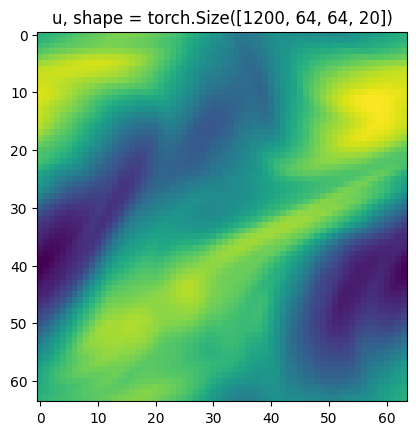

In [11]:
u_data = mat_data.read_file('u')
plt.imshow(u_data[0, :, :, 4].cpu().numpy())
plt.title('u, shape = {}'.format(u_data.shape))
plt.show()

## Model

In [12]:
# Define the model 
model = FNO2DTime().cuda()

## Data Preprocessing

In [14]:
# Create data loaders

# Split data into train and eval
train_data = u_data[:1000, :, :, :]
eval_data = u_data[1000:, :, :, :]

# Split data froom time 0-10 and 10-20
u_train = train_data[:, :, :, :10]
a_train = train_data[:, :, :, 10:]

u_eval = eval_data[:, :, :, :10]
a_eval = eval_data[:, :, :, 10:]

# Define data loaders
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(u_train, a_train),
    batch_size=50, shuffle=True)

eval_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(u_eval, a_eval),
    batch_size=50, shuffle=True)

## Training

In [16]:
loss, mse = train_model(model, train_loader, eval_loader, epochs=100, device='cuda')

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [44:44<00:00, 26.85s/it]


## Results

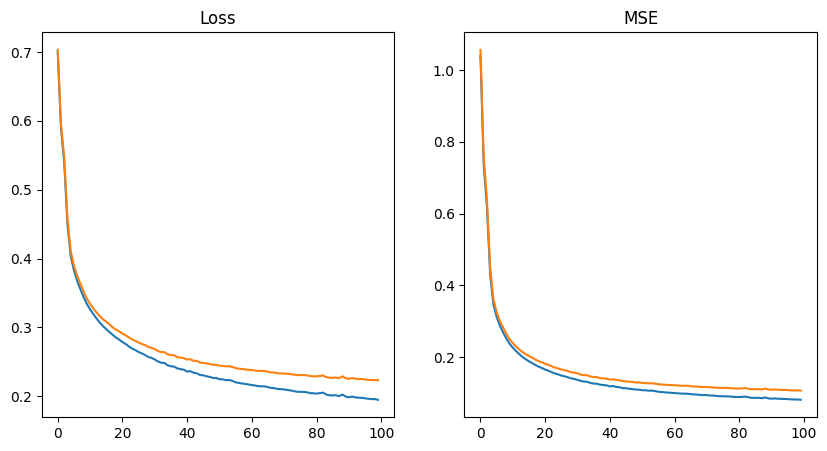

In [17]:
# Plot the loss and mse
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss)
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(mse)
plt.title('MSE')
plt.show()

### Making predictions

In [18]:
data_test = u_data[1000:1001, :, :, :]
data_test.shape

torch.Size([1, 64, 64, 20])

In [19]:
# Make predictions
with torch.no_grad():
    pred = model(data_test[:, :, :, :10].cuda()).cpu()

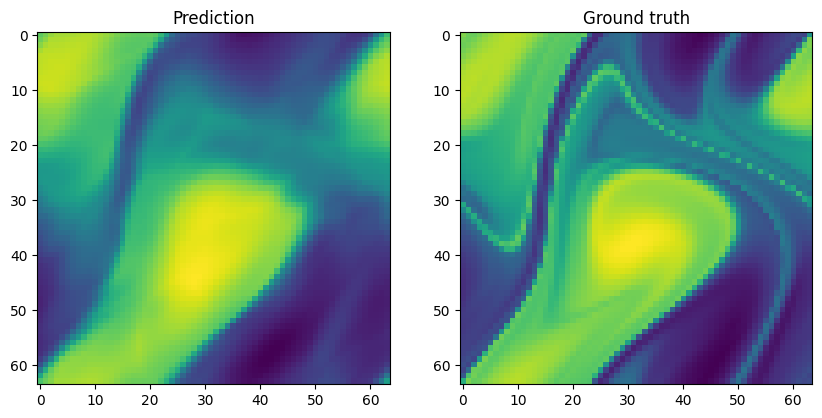

In [27]:
# Compare the prediction with the actual data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pred[0, :, :, -1].numpy())
plt.title('Prediction')
plt.subplot(1, 2, 2)
plt.imshow(data_test[0, :, :, -1].cpu().numpy())
plt.title('Ground truth')
plt.show()